In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import cv2


from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.layers as tfl


In [53]:
pathToAugDatasets = r'E:\AlzheimerMRIScanDataset\AugmentedAlzheimerDataset'

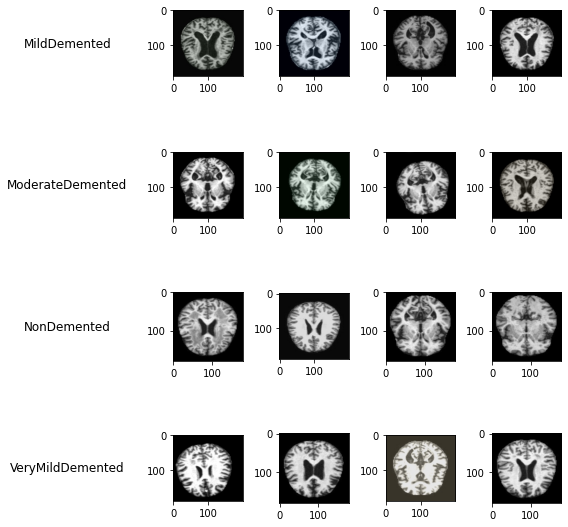

In [54]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

row_labels = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']

images = [Image.open(i) for i in glob.glob(os.path.join(pathToAugDatasets,'MildDemented\*.jpg'))[:16:4]]
images.extend([Image.open(i) for i in glob.glob(os.path.join(pathToAugDatasets,'ModerateDemented\*.jpg'))[:16:4]])
images.extend([Image.open(i) for i in glob.glob(os.path.join(pathToAugDatasets,'NonDemented\*.jpg'))[:16:4]])
images.extend([Image.open(i) for i in glob.glob(os.path.join(pathToAugDatasets,'VeryMildDemented\*.jpg'))[:16:4]])

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i],cmap='gray')
    #ax.axis('off')
    
    if i % 4 == 0:
        row = i // 4
        ax.set_ylabel(row_labels[row], rotation=0, labelpad=80, fontsize=12, va='center')
        #ax.axis('off')
plt.tight_layout()
plt.savefig('disp.jpeg',dpi=600)
plt.show()

## Augmented Data Training

In [57]:

data = []

pbar = tqdm(enumerate(os.listdir(pathToAugDatasets)[:4]))
for i,class_ in pbar:
    ohe = [0,0,0,0]
    ohe[i] += 1
    
    dir_ = os.path.join(pathToAugDatasets,class_)
    
    #pbar2 = tqdm(glob.glob(os.path.join(dir_,'*.jpg')))
    for img in glob.glob(os.path.join(dir_,'*.jpg')):
        row = []
        
        image = Image.open(img)
        img_array = np.array(image.convert('L'))
        
        img_array = cv2.resize(img_array,(200,200))
        row.append(img_array)
        
        row.extend(ohe)
        
        data.append(row)


        


X = [dat[0] for dat in data]
Y = [dat[1::] for dat in data]  
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y,random_state=42,test_size=0.2,shuffle=True)

4it [02:32, 38.16s/it]


In [4]:
len(data)

33984

In [16]:
## save the arrays

np.save('Xtrain_augmented.npy',Xtrain)
np.save('Xtest_augmented.npy',Xtest)
np.save('Ytest_augmented.npy',Ytest)
np.save('Ytrain_augmented.npy',Ytrain)

In [17]:
len(Xtrain)

27187

In [18]:
count=0
for i in range(len(Xtest)):
    if Xtest[i].shape != (200,200):
        print('mismatch',i, Xtest[i].shape)
        count+=1

In [19]:
count

0

In [25]:
#input layer
input_img = tfl.Input(shape=(200,200,1))

conv2d_1 = tfl.Conv2D(filters=16,kernel_size=(8,8),strides=1)(input_img)
relu_1 = tfl.ReLU()(conv2d_1)
maxpool_1 = tfl.MaxPool2D(pool_size=(4,4),strides=4)(relu_1)

BN_1 = tfl.BatchNormalization()(maxpool_1)

conv2d_2 = tfl.Conv2D(filters=32,kernel_size=(4,4),strides=2)(BN_1)
relu_2 = tfl.ReLU()(conv2d_2)
maxpool_2 = tfl.MaxPool2D(pool_size=(2,2),strides=2)(relu_2)

F = tfl.Flatten()(maxpool_2)

outputs = tfl.Dense(4,activation='softmax')(F)

model1 = tf.keras.Model(inputs = input_img, outputs=outputs)

In [28]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
model1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 193, 193, 16)      1040      
                                                                 
 re_lu_6 (ReLU)              (None, 193, 193, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 48, 48, 16)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 48, 48, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 23, 23, 32)        8224

In [29]:
train_dataset = tf.data.Dataset.from_tensor_slices((Xtrain, Ytrain)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((Xtest, Ytest)).batch(32)
history = model1.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
850/850 [==============================] - 510s 598ms/step - loss: 0.8371 - accuracy: 0.6413 - val_loss: 0.6429 - val_accuracy: 0.7393
Epoch 2/10
850/850 [==============================] - 595s 700ms/step - loss: 0.5519 - accuracy: 0.7712 - val_loss: 0.4763 - val_accuracy: 0.8111
Epoch 3/10
850/850 [==============================] - 507s 597ms/step - loss: 0.4605 - accuracy: 0.8159 - val_loss: 0.4767 - val_accuracy: 0.8151
Epoch 4/10
850/850 [==============================] - 502s 590ms/step - loss: 0.3990 - accuracy: 0.8418 - val_loss: 0.4978 - val_accuracy: 0.8136
Epoch 5/10
850/850 [==============================] - 501s 590ms/step - loss: 0.3485 - accuracy: 0.8631 - val_loss: 0.4465 - val_accuracy: 0.8301
Epoch 6/10
850/850 [==============================] - 499s 587ms/step - loss: 0.3158 - accuracy: 0.8778 - val_loss: 0.6142 - val_accuracy: 0.7877
Epoch 7/10
850/850 [==============================] - 501s 590ms/step - loss: 0.2835 - accuracy: 0.8919 - val_loss: 0.8222 -

In [86]:
print(type(Xtrain), type(Ytrain))
print(np.array(Xtrain, dtype=object).shape)
print(np.array(Ytrain, dtype=object).shape)

<class 'list'> <class 'list'>
(27187,)
(27187, 4)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

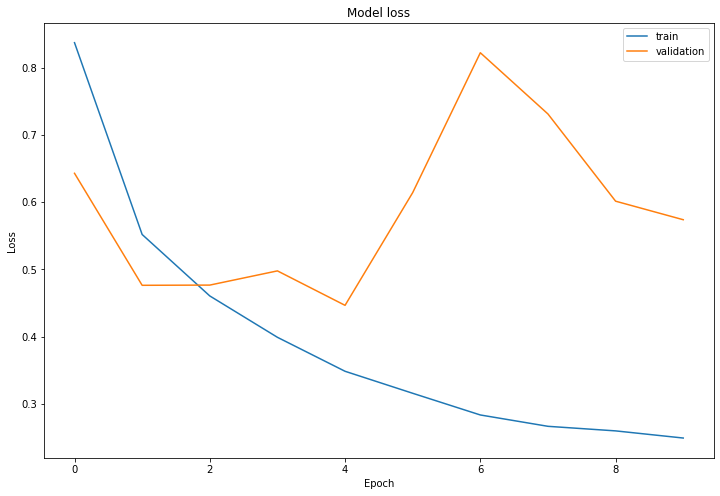

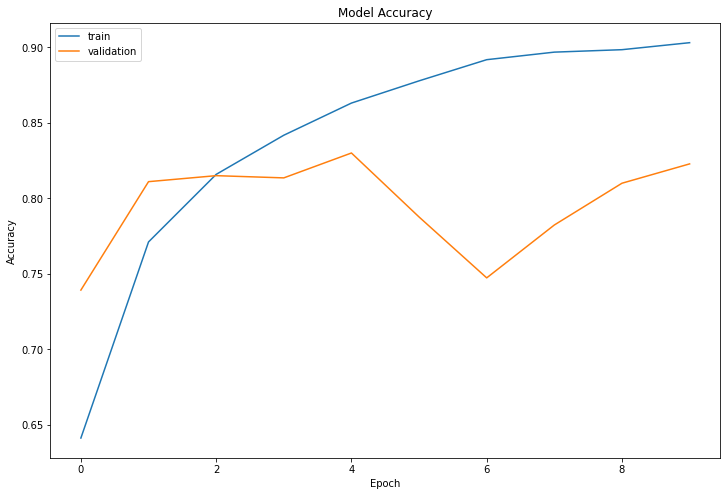

In [30]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [40]:
model1.predict(Xtest[0].reshape(1,200,200,1))

1/1 [==============================] - 0s 41ms/step


array([[5.1446568e-02, 3.0026213e-06, 3.1453216e-01, 6.3401824e-01]],
      dtype=float32)

In [36]:
Xtest[0].shape

(200, 200)

In [41]:
Ytest[0]

[0, 0, 1, 0]

In [44]:
def pred(model,testData):
    Ypred = []
    for i in tqdm(range(len(testData))):
        idx = np.argmax(model.predict(testData[i].reshape(1,200,200,1),verbose=0))
        y = [0,0,0,0]
        y[idx]+=1
        Ypred.append(y)
    
    
    return Ypred
    

In [56]:
Ypred = pred(model1,Xtest)

100%|██████████████████████████████████████████████████████████████████████████████| 6797/6797 [11:19<00:00, 10.00it/s]


In [57]:
sum(np.array([Ypred[i] == Ytest[i] for i in range(len(Ypred))]).astype(int))

5593

In [10]:
5593/6797 #accuracy

0.8228630278063852

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [63]:
cm = confusion_matrix(np.argmax(Ytest,axis=1), np.argmax(Ypred,axis=1))

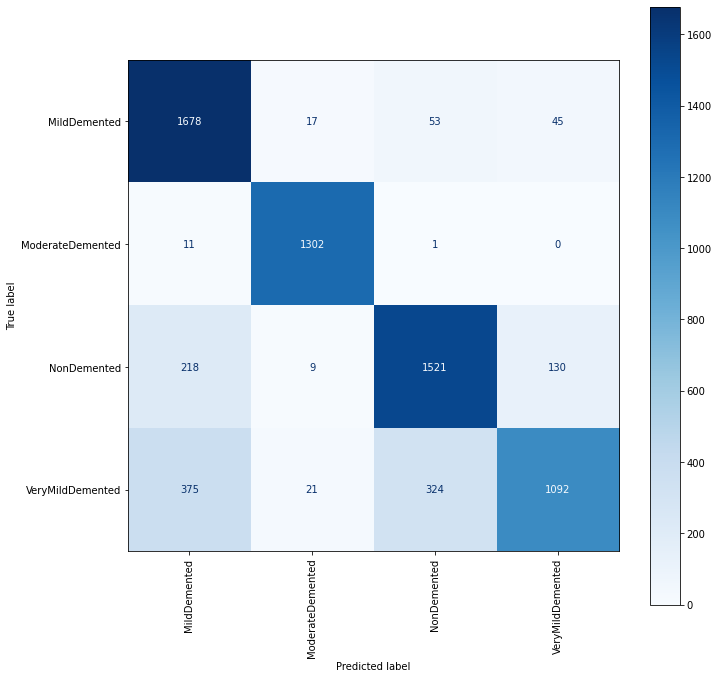

In [73]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])
plt.figure(figsize=(11,11))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.xticks(rotation=90)
plt.show()

In [75]:
from sklearn.metrics import classification_report, accuracy_score
report = classification_report(Ytest, Ypred, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])
print("Classification Report:\n", report)


Classification Report:
                   precision    recall  f1-score   support

    MildDemented       0.74      0.94      0.82      1793
ModerateDemented       0.97      0.99      0.98      1314
     NonDemented       0.80      0.81      0.81      1878
VeryMildDemented       0.86      0.60      0.71      1812

       micro avg       0.82      0.82      0.82      6797
       macro avg       0.84      0.83      0.83      6797
    weighted avg       0.83      0.82      0.82      6797
     samples avg       0.82      0.82      0.82      6797



In [78]:
model1.save('alze1CONV.keras')

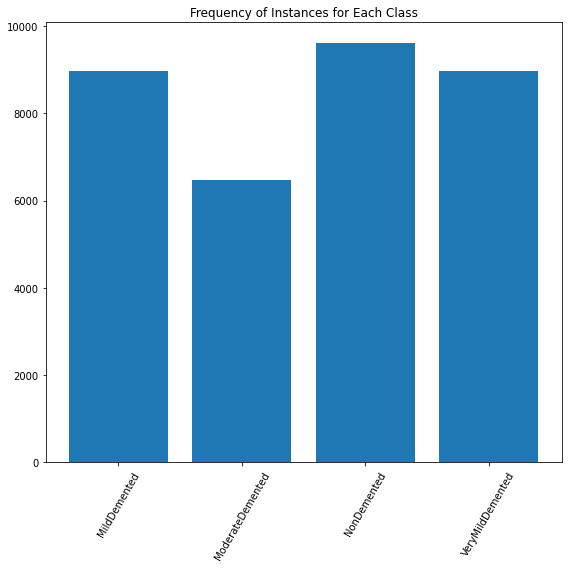

In [55]:
plt.figure(figsize=(8,8))
plt.bar(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'],[len(glob.glob(os.path.join(pathToAugDatasets,'MildDemented\*.jpg'))),
                                                                                len(glob.glob(os.path.join(pathToAugDatasets,'ModerateDemented\*.jpg'))),
                                                                                len(glob.glob(os.path.join(pathToAugDatasets,'NonDemented\*.jpg'))),
                                                                              len(glob.glob(os.path.join(pathToAugDatasets,'VeryMildDemented\*.jpg')))])
plt.title('Frequency of Instances for Each Class')
plt.xticks(rotation=60)
plt.tight_layout()
plt.savefig('freq.jpg',dpi=600)

#### By :  Sudhish Gupta